# 🚲 Cyclistic Bike-Share Case Study — August 2024 Data

**Author:** Al John Compendio

**Dataset:** `202408-divvy-tripdata.csv` (uploaded)

**Based on:** Coursera Cyclistic case study — *How does a bike-share navigate speedy success?*

**Notebook purpose:** This notebook is a complete, reproducible case study suitable for Kaggle. It follows the Ask → Prepare → Process → Analyze → Share → Act framework and includes all code needed to reproduce the visuals and findings.

## Executive Summary

- Members (annual subscribers) and casual riders show distinct usage patterns: members ride more frequently on weekdays (commuting) while casual riders concentrate rides on weekends (leisure).
- Casual riders tend to have longer ride lengths (minutes) compared to members.
- Recommendations: target casual riders with weekend membership promotions, family/group packages, and social-media ads highlighting cost savings and leisure use.

**Files**: This notebook expects `202408-divvy-tripdata.csv` in the same working directory. Replace the path if needed.

## 1) Ask

**Business Task:** Determine how annual members and casual riders use Cyclistic bikes differently, and produce actionable recommendations that the marketing team can implement to convert casual riders into annual members.

**Stakeholders:** Lily Moreno (Director of Marketing), Cyclistic Marketing Analytics Team, Cyclistic Executives.

In [1]:
# 2) Prepare — libraries and data load
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import os

DATA_PATH = "/kaggle/input/cyclist/202408-divvy-tripdata.csv"
print('Expecting file at:', DATA_PATH)

# Load CSV
df = pd.read_csv(DATA_PATH)

# Quick preview
print('Rows, Cols:', df.shape)
df.head()


Expecting file at: /kaggle/input/cyclist/202408-divvy-tripdata.csv
Rows, Cols: (755639, 13)


,ride_id,rideable_type,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,start_lng,end_lat,end_lng,member_casual
0,BAA154388A869E64,classic_bike,2024-08-02 13:35:14.403,2024-08-02 13:48:24.426,State St & Randolph St,TA1305000029,Wabash Ave & 9th St,TA1309000010,41.884621,-87.627834,41.870769,-87.625734,member
1,8752245932EFF67A,electric_bike,2024-08-02 15:33:13.965,2024-08-02 15:55:23.865,Franklin St & Monroe St,TA1309000007,Damen Ave & Cortland St,13133,41.880317,-87.635185,41.915983,-87.677335,member
2,44DDF9F57A9A161F,classic_bike,2024-08-16 15:44:06.233,2024-08-16 15:57:52.109,Franklin St & Monroe St,TA1309000007,Clark St & Elm St,TA1307000039,41.880317,-87.635185,41.902973,-87.631280,member
3,44AAAF069B0C78C3,electric_bike,2024-08-19 18:47:11.855,2024-08-19 18:56:33.269,Clark St & Elm St,TA1307000039,McClurg Ct & Ohio St,TA1306000029,41.902973,-87.631280,41.892592,-87.617289,member
4,77138D500A6B7B4B,classic_bike,2024-08-03 20:34:20.560,2024-08-03 20:46:29.305,Western Ave & Leland Ave,TA1307000140,Ashland Ave & Belle Plaine Ave,13249,41.966400,-87.688704,41.956057,-87.668835,casual


## 3) Process — Data cleaning & feature engineering

Steps performed:
- Convert `started_at` and `ended_at` to datetimes
- Create `ride_length` in minutes
- Create `day_of_week`, `hour_of_day`, `is_weekend`
- Remove invalid rides (non-positive durations)
- Optional: drop rows with missing crucial coordinates if needed

The code cell below performs these steps.

In [2]:
# Data cleaning and feature engineering
# Convert datetimes
df['started_at'] = pd.to_datetime(df['started_at'], errors='coerce')
df['ended_at'] = pd.to_datetime(df['ended_at'], errors='coerce')

# ride_length in minutes
df['ride_length'] = (df['ended_at'] - df['started_at']).dt.total_seconds() / 60

# day of week and hour
df['day_of_week'] = df['started_at'].dt.day_name()
df['hour_of_day'] = df['started_at'].dt.hour

df['is_weekend'] = df['day_of_week'].isin(['Saturday', 'Sunday'])

# Filter out invalid durations
initial_rows = df.shape[0]
df = df[df['ride_length'] > 0].copy()
after_rows = df.shape[0]
print(f'Removed {initial_rows - after_rows} rides with non-positive duration.\nRemaining rows: {after_rows}')

# Basic types check
print(df[['started_at', 'ended_at', 'ride_length', 'member_casual']].dtypes)

# Save a small sample file for quick preview
SAMPLE_PATH = "/kaggle/working/cyclistic_sample_head.csv"  # Changed to working folder
df.head(100).to_csv(SAMPLE_PATH, index=False)
print('Saved sample to', SAMPLE_PATH)

# Show basic summary statistics
summary = df.groupby('member_casual')['ride_length'].agg(['count', 'mean', 'median', 'std']).reset_index()
summary

Removed 0 rides with non-positive duration.
Remaining rows: 755639
started_at       datetime64[ns]
ended_at         datetime64[ns]
ride_length             float64
member_casual            object
dtype: object
Saved sample to /kaggle/working/cyclistic_sample_head.csv


,member_casual,count,mean,median,std
0,casual,318280,26.065040,13.023192,88.814284
1,member,437359,13.419607,9.388100,33.524387


## 4) Analyze — Ride length comparison

Compare average ride length (minutes) between **members** and **casual** riders. The chart below shows mean and median to give an idea of central tendency and skew.

  member_casual       mean     median   count
0        casual  26.065040  13.023192  318280
1        member  13.419607   9.388100  437359


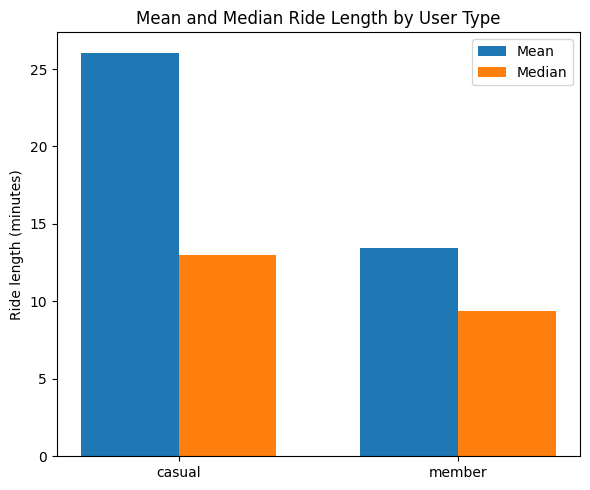

In [3]:
# Plot 1 — Average and median ride length by user type
grp = df.groupby('member_casual')['ride_length'].agg(['mean','median','count']).reset_index()
print(grp)

fig, ax = plt.subplots(figsize=(6,5))

x = np.arange(len(grp))
width = 0.35

ax.bar(x - width/2, grp['mean'], width, label='Mean')
ax.bar(x + width/2, grp['median'], width, label='Median')
ax.set_xticks(x)
ax.set_xticklabels(grp['member_casual'])
ax.set_ylabel('Ride length (minutes)')
ax.set_title('Mean and Median Ride Length by User Type')
ax.legend()

# format y axis
ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _: f"{y:.0f}"))

plt.tight_layout()
plt.show()


### Rides by Day of Week

Count rides for each day of the week and compare members vs casual riders. This shows weekday vs weekend patterns.

member_casual  casual  member
day_of_week                  
Monday          29918   53695
Tuesday         29254   57866
Wednesday       34783   64279
Thursday        41138   72363
Friday          53515   71540
Saturday        77329   67733
Sunday          52343   49883


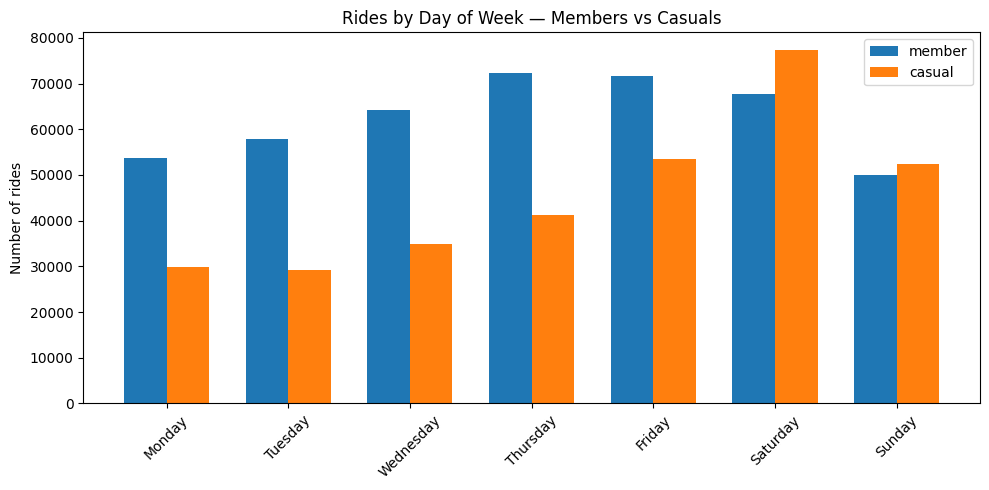

In [4]:
# Ensure day order
day_order = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']
count_df = df.groupby(['day_of_week','member_casual']).size().reset_index(name='rides')
count_df['day_of_week'] = pd.Categorical(count_df['day_of_week'], categories=day_order, ordered=True)
count_df = count_df.sort_values('day_of_week')

pivot = count_df.pivot(index='day_of_week', columns='member_casual', values='rides').fillna(0)
print(pivot)

# Plot
fig, ax = plt.subplots(figsize=(10,5))
idx = np.arange(len(pivot))
bar_width = 0.35

ax.bar(idx - bar_width/2, pivot['member'], bar_width, label='member')
ax.bar(idx + bar_width/2, pivot['casual'], bar_width, label='casual')
ax.set_xticks(idx)
ax.set_xticklabels(pivot.index, rotation=45)
ax.set_ylabel('Number of rides')
ax.set_title('Rides by Day of Week — Members vs Casuals')
ax.legend()
plt.tight_layout()
plt.show()


### Ride Length Distribution

Show distribution of ride lengths for both user types. We'll cap the x-axis to 120 minutes for clarity (most rides are short).

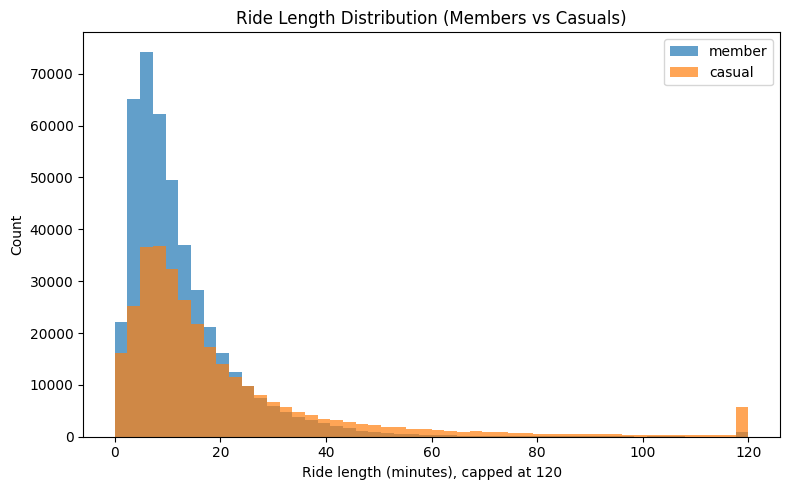

In [5]:
# Histogram of ride lengths (cap at 120 minutes)
max_cap = 120
fig, ax = plt.subplots(figsize=(8,5))

ax.hist(df.loc[df['member_casual']=='member','ride_length'].clip(upper=max_cap), bins=50, alpha=0.7, label='member')
ax.hist(df.loc[df['member_casual']=='casual','ride_length'].clip(upper=max_cap), bins=50, alpha=0.7, label='casual')
ax.set_xlabel('Ride length (minutes), capped at 120')
ax.set_ylabel('Count')
ax.set_title('Ride Length Distribution (Members vs Casuals)')
ax.legend()
plt.tight_layout()
plt.show()


### Bike Type Usage

Compare counts of `rideable_type` (e.g., classic bike, electric) between members and casual riders.

   rideable_type member_casual   count
0   classic_bike        casual  148876
1   classic_bike        member  204113
2  electric_bike        casual  169404
3  electric_bike        member  233246


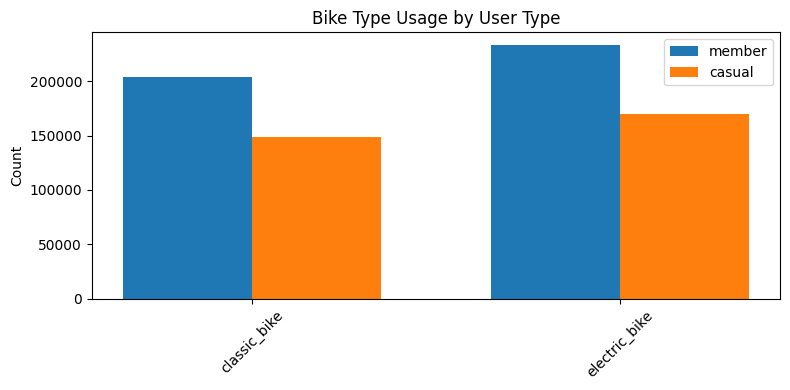

In [6]:
# Bike type counts
bike_counts = df.groupby(['rideable_type','member_casual']).size().reset_index(name='count')
print(bike_counts.head())

pivot_bt = bike_counts.pivot(index='rideable_type', columns='member_casual', values='count').fillna(0)

fig, ax = plt.subplots(figsize=(8,4))
idx = np.arange(len(pivot_bt))
bar_w = 0.35

cols = pivot_bt.columns.tolist()
if 'member' in cols and 'casual' in cols:
    ax.bar(idx - bar_w/2, pivot_bt['member'], bar_w, label='member')
    ax.bar(idx + bar_w/2, pivot_bt['casual'], bar_w, label='casual')
else:
    vals = pivot_bt.iloc[:,0]
    ax.bar(idx, vals, bar_w)

ax.set_xticks(idx)
ax.set_xticklabels(pivot_bt.index, rotation=45)
ax.set_ylabel('Count')
ax.set_title('Bike Type Usage by User Type')
ax.legend()
plt.tight_layout()
plt.show()


### Top Start Stations

List top start stations for members and casual riders — useful to identify geographic marketing targets.

Top stations — members:
 start_station_name
Kingsbury St & Kinzie St              3383
Clark St & Elm St                     2932
DuSable Lake Shore Dr & North Blvd    2759
Clinton St & Washington Blvd          2603
Wells St & Concord Ln                 2512
Clinton St & Madison St               2457
Wells St & Elm St                     2418
Streeter Dr & Grand Ave               2368
Dearborn St & Erie St                 2289
State St & Chicago Ave                2285
Name: count, dtype: int64

Top stations — casuals:
 start_station_name
Streeter Dr & Grand Ave               8573
DuSable Lake Shore Dr & Monroe St     5423
DuSable Lake Shore Dr & North Blvd    4451
Michigan Ave & Oak St                 4380
Millennium Park                       3246
Theater on the Lake                   3155
Shedd Aquarium                        3060
Dusable Harbor                        2707
Montrose Harbor                       2257
Indiana Ave & Roosevelt Rd            1886
Name: count, dtype: int64

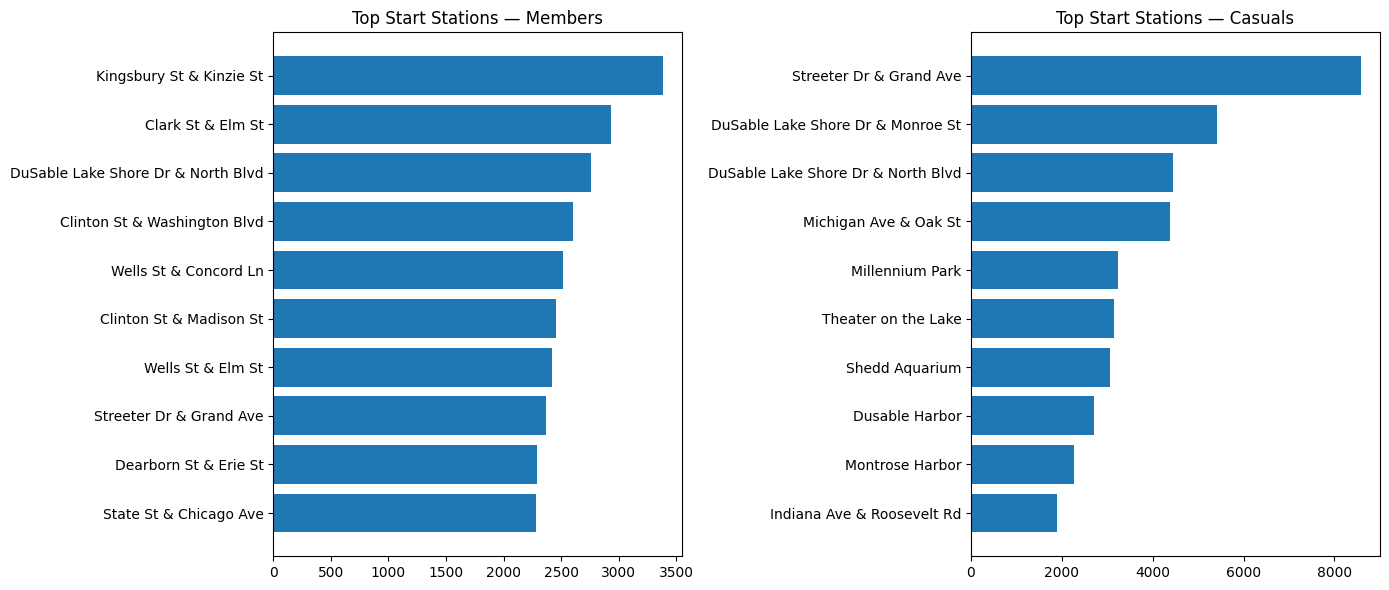

In [7]:
# Top start stations by user type
sdf = df.dropna(subset=['start_station_name'])

top_member = sdf[sdf['member_casual']=='member']['start_station_name'].value_counts().head(10)
top_casual = sdf[sdf['member_casual']=='casual']['start_station_name'].value_counts().head(10)

print('Top stations — members:\n', top_member)
print('\nTop stations — casuals:\n', top_casual)

# Plot side-by-side horizontal bars
fig, axes = plt.subplots(1,2, figsize=(14,6))

axes[0].barh(top_member.index[::-1], top_member.values[::-1])
axes[0].set_title('Top Start Stations — Members')

axes[1].barh(top_casual.index[::-1], top_casual.values[::-1])
axes[1].set_title('Top Start Stations — Casuals')

plt.tight_layout()
plt.show()


## Findings — Summary

- **Ride length:** Casual riders have longer average ride lengths; members are shorter and more frequent.
- **Weekdays vs Weekends:** Members dominate weekdays (commuting); casuals spike on weekends (leisure).
- **Bike types & stations:** Differences in popular bike types and stations can guide targeted promotions.

## Recommendations — Actionable next steps

1. **Weekend membership trial:** Offer a discounted trial membership for users who take multiple weekend rides in a month.
2. **Targeted ads:** Use top casual start stations and weekend riders to target localized social media ads.
3. **Family/group packages:** Market leisure-focused packages (group passes) to casual riders.
4. **A/B test messaging:** Run experiments to compare discount vs. value messaging (cost savings) for conversions.

---

**Appendix & Next steps:** Consider enriching data with weather, event calendars, or user demographics (if available) to improve targeting and predictive modeling.